In [84]:
import glob
from collections import OrderedDict, namedtuple
import warnings
import numpy as np
import scipy.ndimage
from skimage import feature as ski_feature
from skimage.transform import resize as rs

from scipy.stats import probplot, norm
import pylab

import multiprocessing
import matplotlib.pyplot as plt

In [85]:
"""Global definitions and variables for a given run."""

# Global cache of images.
images = {}

# Run specific variables
experiment = 32 # The experiment number. Images for this experiment should be in folder {experiment}/
band = 3 # The band to examine within the experiment
export_gifs = True # Whether gifs should be exported
interactive = True # Whether interactive parts of the script should be run.
recompute = False # Forces recomputation. Warning, will potentially overwrite
                  # other variables.

# Experiment specific variables. These will be overwritten
# if the experiment has already been analyzed.
scale = 768/40.27 # Pixels to um ratio.
frequency = 75 # The frequency of loading 
direction = 2./3 # The slope of the PSBs in the experiment relative to the image.
                 # Seemingly allows for margin of error. 
beam_height = 600 # In pixels
beam_width = 180 # in pixels
flip = True # All PSB slope should be positive. If the slope is negative, a
            # reflection is performed on the picture.

# New experiment specific variables. These values will be ignored
# unless no records exist for the given variable.
# Image loading specific variables.
resize = 0 # Scale factor by which the image should be resized. Set 0 for no resizing.
borders = [50, 140, 30, 40] # Left, Right, Top, Bottom cropping margins for the processed images.
margin_x = [20, 3] # The margin to provide a partially cropped beam,
                   # when determining how to crop the height

# Event capture specific variables.
time_margin = 15
sigma = 0.65

In [86]:
# Load records if possible.
Record = namedtuple("Record",
                    ("scale frequency direction "
                    "height width flipped time_margin bands"))
# Globals associated with each experiment analysis.
# Update this variable accordingly with each analysis performed.
experiments = {
  32: Record(
    scale=768./42.4,
    frequency=75,
    direction=2./3,
    height=575,
    width=270,
    flipped=False,
    time_margin=15,
    bands={
      2: (195, 35),
      3: (252, 30),
      5: (315, 30),
      8: (390, 30),
  }),
  24: Record(
    scale=768./45.43,
    frequency=75,
    direction=.5,
    height=500,
    width=200,
    flipped=True,
    time_margin=60,
    bands={
      2: (480, 25),
      3: (465, 20),
      4: (440, 25),
      5: (412, 25),
      6: (390, 20),
      7: (365, 25),
      8: (345, 20),
  }),
  25: Record(
    scale=768./40.27,
    frequency=75,
    direction=2./3,
    height=600,
    width=180,
    flipped=True,
    time_margin=1,
    bands={
      7: (265, 35),
      8: (210, 35),
      9: (185, 25)
  })
}

# If the experiment is listed, we use the values specified by the `experiments` variable
if experiment in experiments:
  warnings.warn("Overriding definitions for records.")
  (scale, frequency, direction,
   beam_height, beam_width, flipped, time_margin, bands) = experiments[experiment]
  if band in bands:
    start, width = bands[band]
  else:
    warnings.warn(("Band is not defined. Considering whole beam. "
                  " Please redefine `start, width` for a given band."))
    start, width = (0, beam_height)    
else:
  warnings.warn("Could not find record. Relying on global defintions.")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Overriding definitions for records.


In [87]:
def extract_images(src, borders=borders, resize=resize, margin_x=margin_x,
                   beam_width=beam_width, beam_height=beam_height):
  """Extracts a PSB from an image based on lighting hueristics.
  
  Given a beam height and size, determines where the beam is most
  likely to be based on dramaticlighting changes from the background
  to foreground.
  
  Args:
      src: A file name for an expected to be of the form "path/to/image/image_timestamp.bmp" 
      borders: The cropping margins to apply to the image
      resize: The scale factor to resize the image.
      margin_x: Margins by which 

  Returns:
      A tuple of (cycle #, PSB of fixed size (beam_width x beam_height))
  """
  cycle = int(src.split("/")[-1].split("_")[-1].split(".")[0])/1000. * frequency
  image = imageio.imread(src)

  # Go from RGB -> blackwhite and cast
  image = np.rint(np.mean(image, axis=-1)).astype(np.uint8)

  # Resize using skimage.
  if resize:
    image = rs(image, tuple(i * resize for i in image.shape), anti_aliasing=True)

  #Crop borders form image
  image = image[borders[0]:-borders[1], borders[2]:-borders[3]]

  # Pretty reliably finds crop position where the beam occurs.
  # could do convolution like for the height.
  x = np.sum(scipy.ndimage.filters.gaussian_filter(image, 3), axis=0)
  crop_x = np.argmax(np.convolve(x.T, np.ones(beam_width, dtype=int),'valid'))

  # Cropping for height is a little more unstable. As such, smoothing and crop
  # margins were found to help.
  smoothed = scipy.ndimage.filters.gaussian_filter(image, 3)
  smoothed = smoothed[:, crop_x - margin_x[0]:crop_x + margin_x[1]]

  # Attempts find crop position from the top of the beam
  y = np.sum(smoothed, axis=1)
  crop_y = np.argmin(np.convolve(y.T, np.ones(beam_height, dtype=int),'valid'))

  # Apply the crop with a fixed size
  return (cycle, image[crop_y:crop_y + beam_height, crop_x:crop_x + beam_width])

# Extract or load the images relevant to the experiment.
try:
  if recompute: raise
  images = np.load("npy/images_{}.npy".format(experiment)).item()
except:
  pool = multiprocessing.Pool()
  images = OrderedDict(sorted(pool.map(extract_images, glob.glob("images/{}/*.bmp".format(experiment)))))
  pool.close()
  del pool
  np.save("npy/images_{}".format(experiment), images)
  
beam_height, beam_width = images[list(images.keys())[0]].shape
times = list(images.keys())
image = images[times[-1]]

In [88]:
"""Export a gif of the newly cropped images."""
if export_gifs: import imageio
if export_gifs:
  gif = "psb_stable_{}.gif".format(experiment)

  # We can smooth through time too!
  imageio.mimsave(gif, scipy.ndimage.filters.gaussian_filter(
    list(images.values()), 1), fps=60)

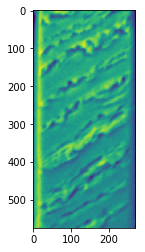

In [89]:
"""Examine the last frame of our image."""
if interactive:
  plt.imshow(scipy.ndimage.filters.gaussian_filter(image, 2))
  plt.show()

In [90]:
def determine_psb_slip_direction(image, sigma=1):
  """Run a gradient on the image for a ball park of the slip direction.
  
  Depending on how the gradient get calculated, the answer might be inverse to
  the gradient.
  
  Args:
    image: The final image in the set (has the most psbs)
    sigma: The amount of smoothing to do on the image prior to running gradient
  Returns: Image of gradients
  """
  filtered = scipy.ndimage.filters.gaussian_filter(image, sigma)
  gx, gy = np.gradient(filtered)
  return np.arctan2(gy,gx)

plt.close("all")
img = determine_psb_slip_direction(image, sigma=3)

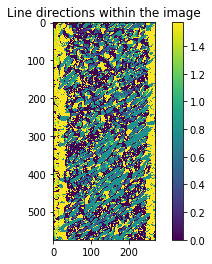

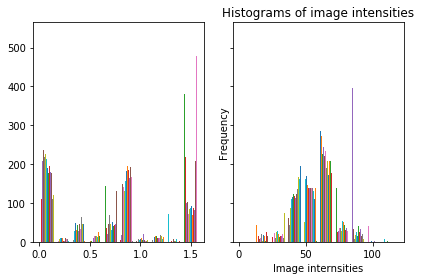

In [128]:
"""Examine gradients in image to quantatively examine the slip direction with
reference to the image."""
if interactive:
  plt.figure()
  plt.title("Line directions within the image")
  plt.imshow(img)
  plt.colorbar()
  # Run a histogram on the gradients to see what's most likely.
  plt.show()
  fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
  plt.title("Histograms of line directions")
  plt.xlabel("Line direction values")
  plt.ylabel("Frequency")
  axs[0].hist(img)
  # Histogram of general intensities
  #axs[1].title = "Histogram of image intensities."
  plt.title("Histograms of image intensities")
  plt.xlabel("Image internsities")
  plt.ylabel("Frequency")
  axs[1].hist(image)

In [92]:
"""Take direction from histogram if not already suggested."""
if not direction: direction = np.mean(img[np.all([img > 0.5, img < 1.], axis=0)])

In [93]:
"""Reorient our image onto the PSB direction."""

def extract_length(image_shape, direction=1):
  """Grab the lines along the slip direction for the entire image.
  
  Args:
    image_shape: shape of the images, should be [x, y, 1].
    direction: The direction of the slip plane we determined.
    
  Returns:
    A tuple of (line lengths, line directions)
  """
  
  sample_count = min(image_shape[:2])

  gradient = direction

  norm = np.linalg.norm
  
  lengths = []
  lins = []
  X = 0
  # Scan along the y axis
  for Y in range(image_shape[0]):
    # Determine whether line will be flush to the right or top of the image.
    if X + Y / gradient > image_shape[1]:
      n = norm([X - image_shape[1], image.shape[1] * gradient])
      x = np.linspace(X, image_shape[1], sample_count)
      y = np.linspace(Y, -image_shape[1] * gradient + Y, sample_count)
    else:
      n = norm([Y / gradient, Y])
      x = np.linspace(0, Y / gradient, sample_count)
      y = np.linspace(Y, 0, sample_count)
    lengths.append(n)
    lins.append(np.vstack((y,x)))

  # Keeps scanning down the y axis, but now the line starts at the bottom of
  # the image. End when line no longer is on the image.
  while -image.shape[1] * gradient + Y + X < image_shape[0]:
    # Determine whether line will be flush to the right or top of the image.
    if X + Y / gradient > image_shape[1]:
      n = norm([X/gradient - image_shape[1], image.shape[1] * gradient - X])
      x = np.linspace(X/gradient, image_shape[1], sample_count)
      y = np.linspace(Y, -image_shape[1] * gradient + Y + X, sample_count)
    else:
      n = norm([X/gradient - (X + Y) / gradient, Y])
      x = np.linspace(X/gradient, (X + Y) / gradient, sample_count)
      y = np.linspace(Y, 0, sample_count)
    X += 1
    lengths.append(n)
    lins.append(np.vstack((y,x)))
    
  return np.array(lengths), np.array(lins)


def extract(image, lins, flip=flip):
  """Apply calculated lines to image."""
  result = []
  if flip: image = np.fliplr(np.flip(image))
  for stack in lins:
    # Extract the values along the line, using cubic interpolation
    result.append(scipy.ndimage.map_coordinates(image, stack))  
  return np.array(result)

lengths, lins = extract_length(image.shape, direction=direction)

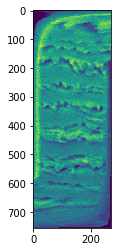

In [110]:
"""Validate that the images are properly sheared."""
if interactive:
  plt.imshow(extract(image, lins))
  plt.show()

In [95]:
"""Grab a particular PSB"""
try:
  if recompute: raise
  extracted = np.load("npy/extracted_{}.npy".format(experiment)).item()
except:
  def f(item):
    key, image = item
    return (key, extract(image, lins))

  pool = multiprocessing.Pool()
  extracted = OrderedDict(sorted(pool.map(f, images.items())))
  pool.close()
  del pool
  np.save("npy/extracted_{}".format(experiment), extracted)
cube = np.array(list(extracted.values()))

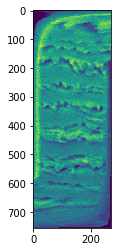

In [96]:
"""Examine the the last frame of our sheared time cube."""
if interactive:
  plt.imshow(cube[-1, :, :])
  plt.show()

In [97]:
"""Export a gif of the sheared time cube."""
if export_gifs:
  gif = "psb_stable_axis_{}.gif".format(experiment)
  imageio.mimsave(gif, cube, fps=30)

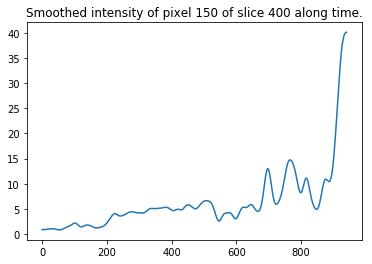

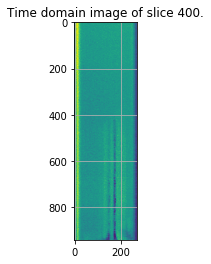

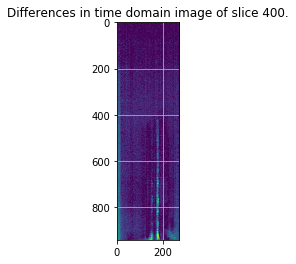

In [98]:
"""Examine intensity profiles over time. This is useful for developing event
determination algorithms."""
if interactive:
  # Checkout our time cube and various slice, in time/space
  offset = 0
  s = 400
  p = 150

  avg_profile = np.average(cube[:10, s, :], axis=0)
  smoothed = scipy.ndimage.filters.gaussian_filter(np.abs(cube[:, s, :]),1)
  smoothed_difference = np.abs(
      scipy.ndimage.filters.gaussian_filter(cube[:, s, :] - avg_profile, 1))

  # t = 180 in ex. 32 is a good example of little change
  plt.title("Smoothed intensity of pixel {} of slice {} along time.".format(p, offset + s))
  plt.plot(scipy.ndimage.filters.gaussian_filter(smoothed_difference[:, p], 9))
  plt.show()

  plt.title("Time domain image of slice {}.".format(offset + s))
  plt.imshow(smoothed)
  plt.grid()
  plt.show()

  plt.title("Differences in time domain image of slice {}.".format(offset + s))
  plt.imshow(smoothed_difference)
  plt.grid()
  plt.show()

In [99]:
"""Methods to extract the events from each time slice."""
def determine_event(time_slice, margin=time_margin):
  """Determine the cycle at which an 'event' occurs. This dramatic change
  should indicate a PSB propagating at this time."""
  # Some what well studied. My current stablization is a little noisy, so not
  # great, but has the potential to be better.
  # This event determination is a little bit of a hack for now. To revisit.
  # https://en.wikipedia.org/wiki/Step_detection
  s = []
  for pivot in range(margin, len(time_slice) - margin):
    s.append(np.abs(np.std(time_slice[:pivot]) - np.std(time_slice[pivot:])))
  return margin + np.argmax(s)


def velocity_profile(S, cube=cube, times=times, sigma=sigma, length=None, offset=0):
  """Grab all 'events' for a given slice.
  
  Args:
    S: the slice index to look at
    scaled: Whether the results should be scaled. Unscaled fit nicely on the
      time slice pictures.
    sigma: Smooothing parameter prior to event detection. High smoothing
      actually produces some nicer contours.
  
  """
  #cut = scipy.ndimage.filters.gaussian_filter(
  #    cube[:, S, :] - np.average(cube[:10, S, :], axis=0), sigma)
  cut = ski_feature.canny(cube[:, S, :], sigma=sigma)

  if not length:
    length = lengths[S + offset]
  k = scale / length
  
  events = []
  scaled_events = []
  for i in range(cut.shape[-1]):
    events.append((i, determine_event(cut[:, i])))
    scaled_events.append((k * i, times[events[-1][1]]))
    
  return list(zip(*scaled_events)), list(zip(*events))

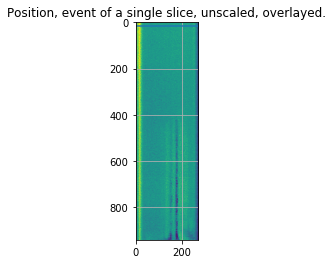

In [100]:
"""Examine profiles for select slice."""
if interactive:
  scaled_profile, profile = velocity_profile(s)
  plt.title("Position, event of a single slice, unscaled, overlayed.")
  plt.plot(*profile)
  plt.imshow(smoothed)
  plt.grid()
  plt.show()

In [101]:
"""Grab events for entire PSB"""
try:
  if recompute: raise
  vs = np.load("npy/vs_{}.npy".format(experiment))
except:
  pool = multiprocessing.Pool()
  vs = pool.map(velocity_profile, range(cube.shape[1]))
  pool.close()
  del pool
  vs = np.array(list(zip(*vs)))
  np.save("npy/vs_{}".format(experiment), vs)

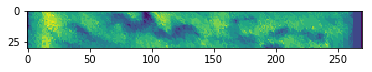

In [102]:
"""Choose a particular psb from the sheared images."""
if interactive:
  # Check out our slice

  ## Play with cropping values here, and record in experiments
  ## definition in cell #3
  # width = 30
  # start =  390

  ## It may also be desireable to overwrite the band # here for quick
  ## iteration.
  # band = 1

  # plt.imshow(cube[-1, start:start + width, :])
  plt.imshow(cube[-1, start:start + width])
  plt.show()

In [103]:
# Parse vs into scaled and unscaled parts.
scaled = vs[0, start:start + width, :, :]
unscaled = vs[1, start:start + width, :, :]

# Average said events for a representation of event occurence
# within an entire PSB.
XY = np.mean(scaled, axis=0)
raw = np.mean(unscaled, axis=0)

In [104]:
"""Massage and filter data for extreme outliers."""

time_margin = 1

def flatten(v):
  return np.array(list(zip(*sum([list(zip(*sl)) for sl in v], []))))

def filter_slices(xy, ab, lower=times[time_margin], upper=times[-time_margin]):
  return ab.T[np.all([xy[1, :] > lower, xy[1, :] < upper], axis=0)].T

points = flatten(scaled)
points_raw = flatten(unscaled)
lin = np.linspace(0, np.max(points[0]), beam_width)
indices = np.tile(list(range(beam_width)), width)

indices = filter_slices(points, indices)
points_raw = filter_slices(points, points_raw)
points = filter_slices(points, points)

In [105]:
"""Extract the minimum events for an entrie band."""
convex_hull = [min(list(points[1][indices == i]) + [list(images.keys())[-time_margin]]) for i in range(beam_width)]
convex_hull_raw = [min(list(points_raw[1][indices == i]) + [len(images) - time_margin]) for i in range(beam_width)]

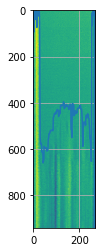

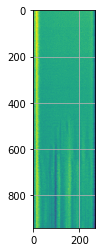

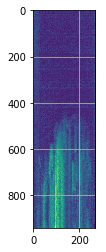

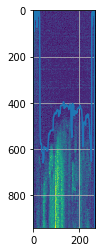

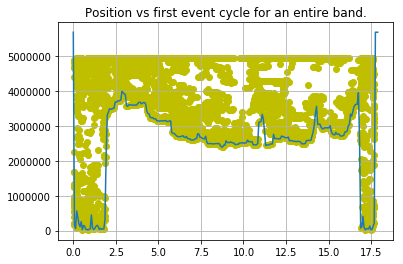

In [106]:
# The velocity of a given nucleation should be slope^-1
# A nucleation event should be early, so we expect we can see these as
#
#   \     /
#  S \   / Q
#     \ /
#      v
#
# Where S^-1 would be speed of the left front, and Q^-1, the speed of the
# right front.
#
# It's worth noting, that mean may be incorrect. Each segment may have a
# different length. Depending on where the PSB was chosen, you may have to
# adjust for size considerations. However, with a small band they should only
# vary slightly. So this provides a general idea regardless

plt.imshow(np.mean(cube[:, start:start + width, :], axis=1))
plt.plot(raw[0, :], np.array(convex_hull_raw))
plt.savefig("svg/band{}_{}.svg".format(experiment, band))
plt.grid()
plt.show()
plt.imshow(np.mean(cube[:, start:start + width, :], axis=1))
plt.grid()
plt.show()
plt.imshow(np.std(cube[:, start:start + width, :], axis=1))
plt.grid()
plt.show()
plt.imshow(np.std(cube[:, start:start + width, :], axis=1))
plt.plot(raw[0, :], convex_hull_raw)
plt.grid()
plt.show()
plt.title("""Position vs first event cycle for an entire band.""") 
plt.plot(points[0], points[1], "oy", zorder=-1)
plt.plot(lin, convex_hull)
plt.grid(True)
plt.show()

np.savetxt("csv/dump_{}_band_{}.csv".format(experiment, band), np.array([lin, convex_hull]).T, delimiter=",")

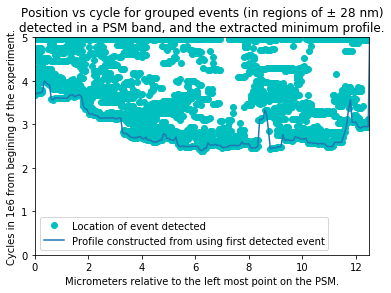

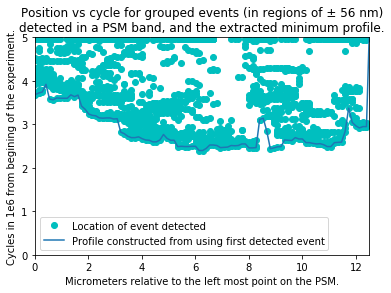

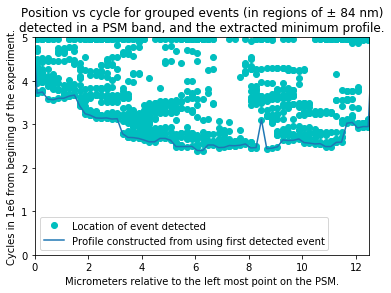

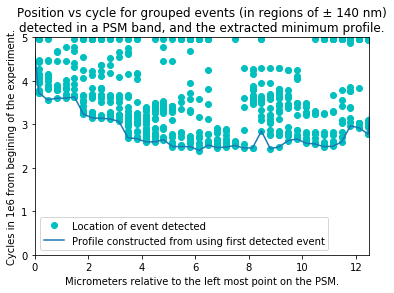

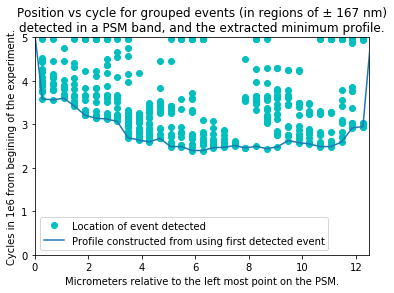

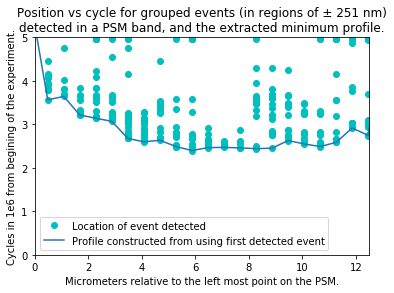

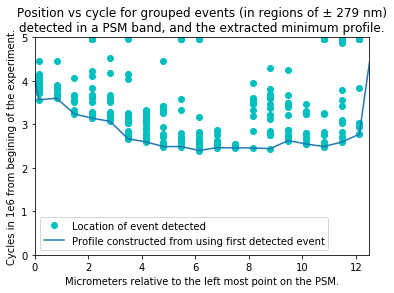

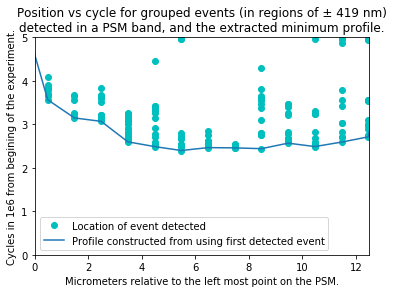

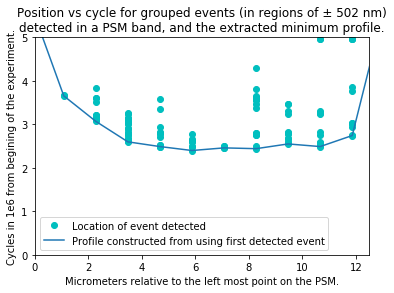

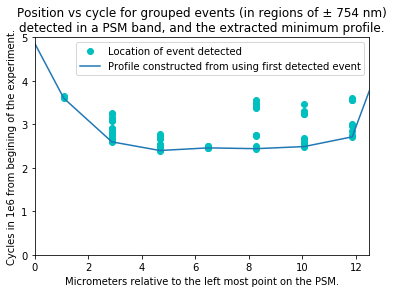

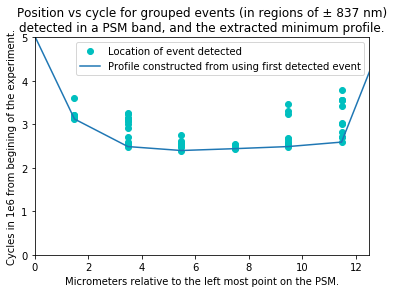

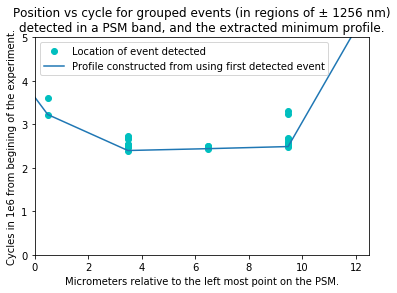

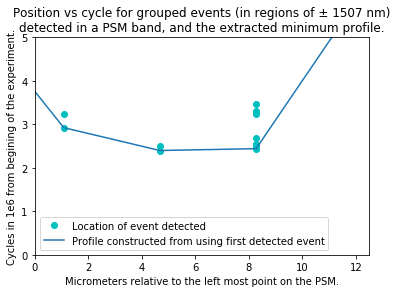

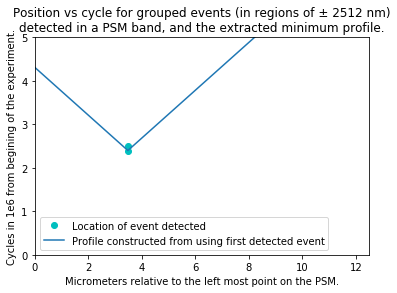

In [107]:
"""By using bucketing as a noise reduction technique, we ensure that the general shape of
the profile is not compromised while reducing event detection mistakes."""
def make_smooth_profile(bucket):
    """Groups all terms into 'bucket' sized groups and then performs aggregation."""
    scaled_temp = np.min(np.reshape(scaled, [width, 2, bucket, -1]), axis=-1)
    unscaled_temp = np.min(np.reshape(unscaled, [width, 2, bucket, -1]), axis=-1)

    points = flatten(scaled_temp)
    points_raw = flatten(unscaled_temp)
    lin = np.linspace(0, np.max(points[0]), bucket)
    indices = np.tile(list(range(bucket)), width)

    indices = filter_slices(points, indices)
    points_raw = filter_slices(points, points_raw)
    points = filter_slices(points, points)
    points = np.array([points[1], points[0]])
    indices = filter_slices(points, indices, upper=15, lower=2.5)
    points = filter_slices(points, points, upper=15, lower=2.5)
    points = np.array([points[1], points[0]])
    
    convex_hull = [min(list(points[1][indices == i]) + [list(images.keys())[-time_margin]])/1e6 for i in range(bucket)]

    np.savetxt("csv/dump_{}_band_{}_bucket_{}.csv".format(experiment, band, beam_width//bucket), np.array([lin, convex_hull]).T, delimiter=",")
    plt.title("""Position vs cycle for grouped events (in regions of ± {:.0f} nm)
detected in a PSM band, and the extracted minimum profile.""".format(1e3 * (beam_width//bucket) * (scale / lengths[start]) / 2))
    plt.plot(points[0]  - 2.5, points[1]/1e6, "oc", label="Location of event detected", zorder=-1)
    plt.plot(lin - 2.5, convex_hull, label="Profile constructed from using first detected event")
    plt.ylabel("""Cycles in 1e6 from begining of the experiment.""")
    plt.xlabel("""Micrometers relative to the left most point on the PSM.""")
    plt.xlim(0, 12.5)
    plt.ylim(0, 5)
    plt.legend()
    plt.savefig("svg/band{}_{}__bucket_{}.svg".format(experiment, band, beam_width//bucket))
    plt.show()
    
def factors(n):
    """A nice way to generate the factors of a number."""
    r = np.arange(1, int(n ** 0.5) + 1)
    x = r[np.mod(n, r) == 0]
    return list(sorted(np.concatenate((x, n // x), axis=None), reverse=True))

# The final 2 factors produce useless plots, thus we ignore them
for factor in factors(beam_width)[:-2]:
    make_smooth_profile(factor)

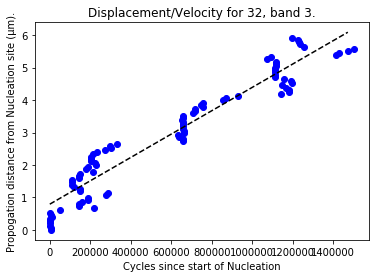

LinregressResult(slope=3.5970383950405463e-06, intercept=0.7933736118796091, rvalue=0.9612502718040954, pvalue=5.017718315964423e-51, stderr=1.0996844918484915e-07)

In [108]:
"""Extract a time/displacement graph for a segment in the profile."""

def filter_segment(xy, ab, lower=5, upper=8):
  ab = ab[:, np.all([xy[0, :] > lower, xy[0, :] < upper], axis=0)]
  return ab

def fit_segment(xy, lower=5, upper=8, right=False, preserve=False, plot=True):
  # Crop to the segement of the band
  xy = filter_segment(xy, xy, lower=lower, upper=upper)

  npmax, npmin = np.max, np.min
  if right:
    npmax, npmin = np.min, np.max

  # Adjust so t=0 is nucleation event
  if not preserve: xy[1, :] -= np.min(xy[1, :])

  # Adjust so displacement is positivly relative to displacement
  if not preserve: xy[0, :] -= npmax(xy[0, :])

  if not right and not preserve:
    xy[0, :] *= -1

  # Swap, because displacement time graph, should be displacement v time.
  xy = np.array([xy[1, :], xy[0, :]])

  # Provide a linear fit.
  fit = np.polyfit(xy[0, :], xy[1, :], 1)
  fit_fn = np.poly1d(fit)

  M = np.max(xy[0, :])
  X = np.arange(0, M, M/48)
  if plot:
    plt.title("Displacement/Velocity for {}, band {}.".format(experiment, band))
    plt.xlabel("Cycles since start of Nucleation")
    plt.ylabel(u"Propogation distance from Nucleation site (μm).")
    plt.plot(xy[0, :], xy[1, :], 'bo', X, fit_fn(X), '--k')
    plt.savefig("svg/speed{}_{}.svg".format(experiment, band))
    plt.show()
  return scipy.stats.linregress(*xy)

line = fit_segment(np.array([lin, convex_hull]), lower=2.5, upper=8.5, right=False)
line

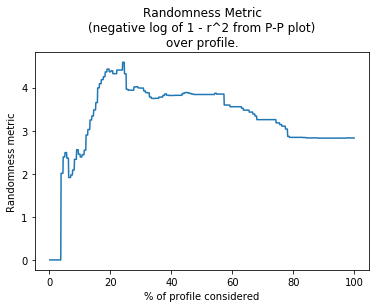

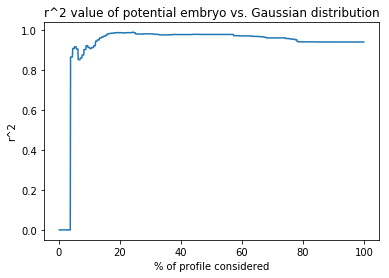

239
7.05 micrometer long embyro spanning from position 6.91 to 13.96,
correlated to Gaussian noise with an r^2 of 0.990


In [136]:
"""Determine a likely embryo from the fit of the profile to randomness."""
def embryo(xy, lower=2.5, upper=15, debug=False, plot=True):
  """Determines embyronic width of a profile.
  Starting with the lowest point on the profile, determines if a
  collection of points is likely random by comparion to gassian distribution.
  The collection is then expanded by the surrounding lowest points.
  
  Args:
      xy: The profile to consider
      lower: The lower bound on the profile to be considered.
      upper: The upper bound on the profile to be considered.
      debug: Produce additional plots and logs
      plot: Produce plot for randomness metrics

  Returns:
      tuple of embyro start, embyro end, embryo length, standard deviation, r^2 in embryo
  """
  gradations = np.arange(.1, 100, .1)
  xy = filter_segment(xy, xy, lower=lower, upper=upper)
  line_xy = filter_segment(xy, xy, lower=5, upper=12)
  xy = np.array([xy[1, :], xy[0, :]])
  line_xy = np.array([line_xy[1, :], line_xy[0, :]])
  line = fit_segment(line_xy, lower=0, upper=np.max(line_xy), plot=debug)
  if debug: print(line, np.min(xy[0, :]))
  pps = None
  if debug: pps=pylab
    
  def f(e):
    gaussian = filter_segment(xy, xy, lower=0, upper=np.min(xy[0, :]) + line.stderr * e)
    _, (c, i, rSquared) = probplot(gaussian[0, :], dist='norm', plot=pps)
    return rSquared

  rs = np.array(list(map(f, gradations)))
  selection = np.argmax(rs)
  if plot:
    plt.show()
    plt.title("""Randomness Metric
(negative log of 1 - r^2 from P-P plot)
over profile.""")
    plt.ylabel("Randomness metric")
    plt.xlabel("% of profile considered")
    plt.plot(gradations, -np.log(1 - rs))
    plt.savefig("svg/random{}_{}.svg".format(experiment, band))
    plt.show()
    plt.title("r^2 value of potential embryo vs. Gaussian distribution")
    plt.ylabel("r^2")
    plt.xlabel("% of profile considered")
    plt.plot(gradations, rs)
    plt.show()
    np.savetxt("csv/randomraw_{}_band_{}.csv".format(experiment, band), np.array([gradations, rs]).T, delimiter=",")
    print(selection)

  std = gradations[selection] * line.stderr
  f(gradations[np.argmax(rs)])
  filt = filter_segment(xy, xy, lower=0, upper=np.min(xy[0, :]) + std)[1, :]
  plt.close("all")
  return np.min(filt), np.max(filt), np.max(filt) - np.min(filt), std, np.max(rs)

print("""{2:.2f} micrometer long embyro spanning from position {0:.2f} to {1:.2f},
correlated to Gaussian noise with an r^2 of {4:.3f}""".format(
    *embryo(np.array([lin, convex_hull]), lower=2.5, upper=16.5)))